# Using ML to predict employee churn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
%matplotlib inline

In [2]:
turnover = pd.read_csv("turnover.csv")

In [3]:
turnover.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


A quick look at the data just to check if there are obvious inaccuracies in the dataset.<br>
`churn` would be our target variable<br>
`deparment` and `salary` are categorical variables that we would need to transform

### Exploratory Data Analysis

In [4]:
turnover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction            14999 non-null float64
evaluation              14999 non-null float64
number_of_projects      14999 non-null int64
average_montly_hours    14999 non-null int64
time_spend_company      14999 non-null int64
work_accident           14999 non-null int64
churn                   14999 non-null int64
promotion               14999 non-null int64
department              14999 non-null object
salary                  14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


There are no missing data :) (very rare) <br>
The dataset consists of 14999 rows<br>
There are 9 features (the tenth column being our target variable)<br>
and 2 columns of object (string) type

In [5]:
turnover.describe()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The `.describe()` method gives a nice statistical description of the numeric type columns. <br>
`churn` and `work_accident` looks a bit strange, we know `churn` is the target variable with either `1` if the left and `0` if they stayed.<br>
Let's check the values in work_accident`

In [6]:
turnover.work_accident.value_counts()

0    12830
1     2169
Name: work_accident, dtype: int64

Checking the `work_accident` column it looks like it's a Boolean with `1` if they were involved in a work accident and `0` if they were not.

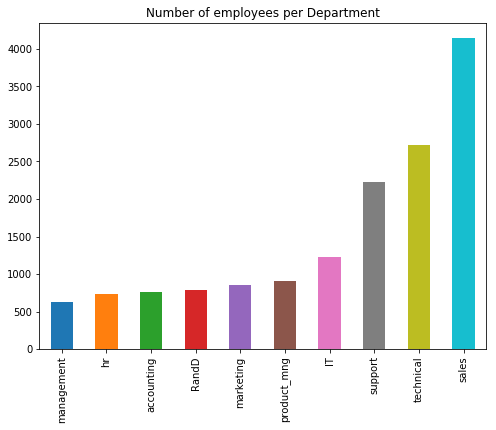

In [7]:
turnover.department.value_counts().sort_values().plot(kind='bar', 
                                                      title='Number of employees per Department', 
                                                      figsize=(8,6));
plt.show()

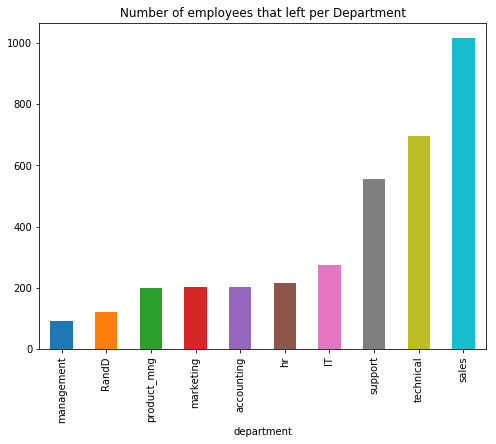

In [8]:
turnover.groupby('department')['churn'].sum().sort_values().plot(kind='bar', 
                                                                 title='Number of employees that left per Department', 
                                                                 figsize=(8,6))
plt.show()

It makes sense that the top four biggest departments would have the highest churn rate.<br>
The HR department however has one of the lowest number of employees but is in the top 5 of employee churn rate.

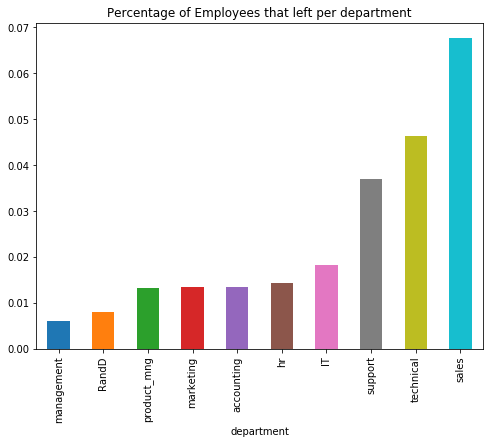

In [9]:
churn_department = turnover.groupby('department')['churn'].sum()
churn_dept_percentage = churn_department/len(turnover)
churn_dept_percentage.sort_values().plot.bar(title='Percentage of Employees that left per department', 
                                             figsize=(8,6))
plt.show()

In [10]:
churn_dept_percentage.sort_values(ascending=False)#.plot.box()

department
sales          0.067605
technical      0.046470
support        0.037002
IT             0.018201
hr             0.014334
accounting     0.013601
marketing      0.013534
product_mng    0.013201
RandD          0.008067
management     0.006067
Name: churn, dtype: float64

Looking at the per department percentage of emplyees that left relative to it's size we see that even though the HR department has a higher churn rate than expected, there is no need to panic. I would inform management to look into the matter further.

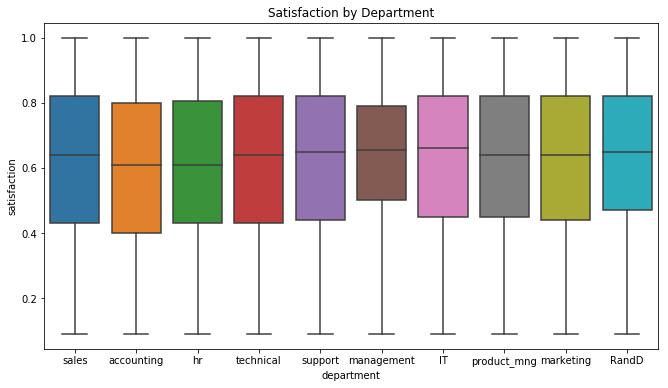

In [11]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='department', y='satisfaction', data=turnover).set_title("Satisfaction by Department")
plt.show()

Satisfaction levels are more less similar. One does notice the smaller range of management.<br>
This explains why this department has the least churn rate.<br>
Accounting has one of the lowest mean satisfaction levels, as well as a very broad range, yet it is one of the departments with the lowest churn rate

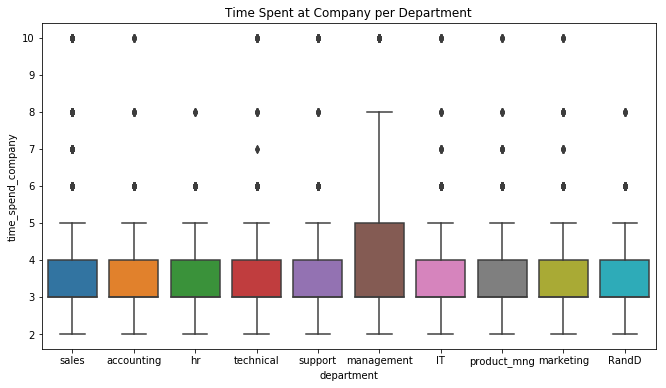

In [12]:
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='department', y='time_spend_company', data=turnover).set_title("Time Spent at Company per Department")
plt.show()

In [13]:
turnover.groupby('department').describe()

average_montly_hours                                              \
                           count        mean        std   min     25%    50%   
department                                                                     
IT                        1227.0  202.215974  50.688311  96.0  160.00  199.0   
RandD                      787.0  200.800508  49.253223  98.0  157.00  200.0   
accounting                 767.0  201.162973  51.108274  97.0  153.50  199.0   
hr                         739.0  198.684709  50.366214  98.0  152.00  197.0   
management                 630.0  201.249206  47.382452  97.0  161.00  204.0   
marketing                  858.0  199.385781  49.356930  96.0  154.00  198.0   
product_mng                902.0  199.965632  50.112636  98.0  155.00  198.0   
sales                     4140.0  200.911353  49.560393  96.0  156.00  201.0   
support                   2229.0  200.758188  50.023687  96.0  155.00  200.0   
technical                 2720.0  202.497426  50.596130  97.0  157.75  201.0   

                             churn           ...  time_spend_company        \
                75%    max   count      mean ...                 75%   max   
department                                   ...                             
IT           245.00  308.0  1227.0  0.222494 ...                 4.0  10.0   
RandD        248.00  308.0   787.0  0.153748 ...                 4.0   8.0   
accounting   247.00  310.0   767.0  0.265971 ...                 4.0  10.0   
hr           242.00  310.0   739.0  0.290934 ...                 4.0   8.0   
management   243.00  307.0   630.0  0.144444 ...                 5.0  10.0   
marketing    242.00  310.0   858.0  0.236597 ...                 4.0  10.0   
product_mng  244.00  310.0   902.0  0.219512 ...                 4.0  10.0   
sales        245.00  310.0  4140.0  0.244928 ...                 4.0  10.0   
support      246.00  310.0  2229.0  0.248991 ...                 4.0  10.0   
technical    246.25  310.0  2720.0  0.256250 ...                 4.0  10.0   

            work_accident                                               
                    count      mean       std  min  25%  50%  75%  max  
department                                                              
IT                 1227.0  0.133659  0.340425  0.0  0.0  0.0  0.0  1.0  
RandD               787.0  0.170267  0.376106  0.0  0.0  0.0  0.0  1.0  
accounting          767.0  0.125163  0.331120  0.0  0.0  0.0  0.0  1.0  
hr                  739.0  0.120433  0.325688  0.0  0.0  0.0  0.0  1.0  
management          630.0  0.163492  0.370108  0.0  0.0  0.0  0.0  1.0  
marketing           858.0  0.160839  0.367597  0.0  0.0  0.0  0.0  1.0  
product_mng         902.0  0.146341  0.353644  0.0  0.0  0.0  0.0  1.0  
sales              4140.0  0.141787  0.348874  0.0  0.0  0.0  0.0  1.0  
support            2229.0  0.154778  0.361774  0.0  0.0  0.0  0.0  1.0  
technical          2720.0  0.140074  0.347127  0.0  0.0  0.0  0.0  1.0  

[10 rows x 64 columns]

that's abit too much detail.<br>
maybe this is better.

In [14]:
turnover.groupby('department').agg(['mean', 'std'])

satisfaction           evaluation           number_of_projects  \
                    mean       std       mean       std               mean   
department                                                                   
IT              0.618142  0.249903   0.716830  0.164508           3.816626   
RandD           0.619822  0.245269   0.712122  0.165093           3.853875   
accounting      0.582151  0.255235   0.717718  0.171904           3.825293   
hr              0.598809  0.247929   0.708850  0.174584           3.654939   
management      0.621349  0.227747   0.724000  0.160263           3.860317   
marketing       0.618601  0.244280   0.715886  0.173447           3.687646   
product_mng     0.619634  0.242279   0.714756  0.178147           3.807095   
sales           0.614447  0.250251   0.709717  0.171459           3.776329   
support         0.618300  0.246406   0.723109  0.171224           3.803948   
technical       0.607897  0.254193   0.721099  0.173364           3.877941   

                      average_montly_hours            time_spend_company  \
                  std                 mean        std               mean   
department                                                                 
IT           1.221658           202.215974  50.688311           3.468623   
RandD        1.164682           200.800508  49.253223           3.367217   
accounting   1.261288           201.162973  51.108274           3.522816   
hr           1.229168           198.684709  50.366214           3.355886   
management   1.181271           201.249206  47.382452           4.303175   
marketing    1.211713           199.385781  49.356930           3.569930   
product_mng  1.244047           199.965632  50.112636           3.475610   
sales        1.242798           200.911353  49.560393           3.534058   
support      1.212096           200.758188  50.023687           3.393001   
technical    1.258948           202.497426  50.596130           3.411397   

                      work_accident               churn           promotion  \
                  std          mean       std      mean       std      mean   
department                                                                    
IT           1.408302      0.133659  0.340425  0.222494  0.416091  0.002445   
RandD        1.214247      0.170267  0.376106  0.153748  0.360937  0.034307   
accounting   1.404650      0.125163  0.331120  0.265971  0.442137  0.018253   
hr           1.169510      0.120433  0.325688  0.290934  0.454501  0.020298   
management   2.425715      0.163492  0.370108  0.144444  0.351819  0.109524   
marketing    1.536907      0.160839  0.367597  0.236597  0.425240  0.050117   
product_mng  1.428644      0.146341  0.353644  0.219512  0.414146  0.000000   
sales        1.512307      0.141787  0.348874  0.244928  0.430096  0.024155   
support      1.340860      0.154778  0.361774  0.248991  0.432525  0.008973   
technical    1.262619      0.140074  0.347127  0.256250  0.436642  0.010294   

                       
                  std  
department             
IT           0.049406  
RandD        0.182134  
accounting   0.133952  
hr           0.141112  
management   0.312543  
marketing    0.218313  
product_mng  0.000000  
sales        0.153548  
support      0.094319  
technical    0.100955

### Turn over rate:

In [15]:
n_employees = len(turnover)
print(turnover.churn.value_counts()/n_employees*100)

0    76.191746
1    23.808254
Name: churn, dtype: float64


The percentage of employee that left the company is around 24%, with 76% of employees choosing to stay with the company.

### Correlations

In [16]:
turnover.corr()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion
satisfaction,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_of_projects,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
churn,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


It is easier to visualise correlations in a heatmap

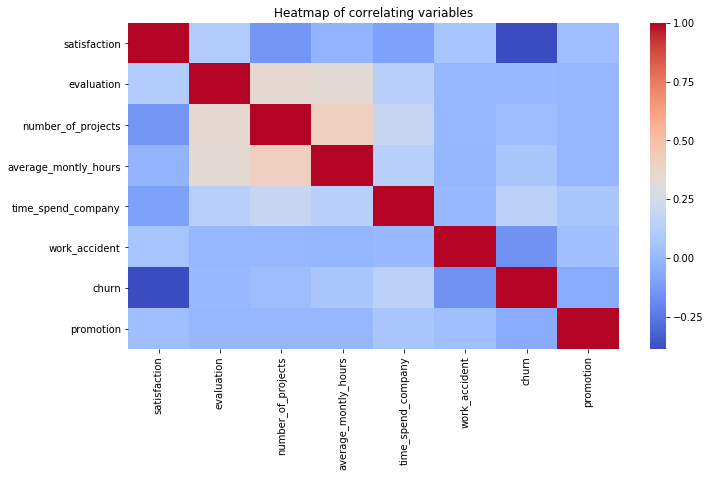

In [17]:
fig, ax = plt.subplots(figsize=(11,6))
sns.heatmap(turnover.corr(), cmap='coolwarm')
plt.title('Heatmap of correlating variables')
plt.show()

In [18]:
turnover[['satisfaction', 'churn']].corr()

,satisfaction,churn
satisfaction,1.000000,-0.388375
churn,-0.388375,1.000000


There is a strong negative correlation between employee satisfaction and churn. <br> Which means the higher the employees satisfaction, the less likely the employee is to leave the company.

---

### Categorical Variables

#### salary column


The salary column is an ordinal categrical feature, meaning 'medium' is higher than 'low' but lower than 'high' 

In [19]:
turnover.salary = turnover.salary.astype('category')

In [20]:
# order salary category in ascending order
turnover.salary = turnover.salary.cat.reorder_categories(['low', 'medium', 'high'])

Since sklearn models only works with numerical type data, we convert the categories into codes:

In [21]:
turnover.salary = turnover.salary.cat.codes

In [22]:
turnover.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


Looking at the data now; <br>'low' is coded as `0` <br> 'medium' is coded as `1` and <br>'high' as `2` 

#### department column


The department variable names the different departments each employee belongs to. There is no heirarchy with one department being "higher" than another.<br>These are called nominal variables, and the order doesn't matter.<br>
There are many ways to create dummy variables but the easiest is to use the Pandas `.get_dummies()` method. <br>
To avoid the ['dummy trap'](insert_link) we set the `drop_first` parameter to True.

In [23]:
departments = pd.get_dummies(turnover.department, drop_first=True)

Lets have a look at the new departments dataframe:

In [24]:
departments.tail()

,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
14994,0,0,0,0,0,0,0,1,0
14995,0,0,0,0,0,0,0,1,0
14996,0,0,0,0,0,0,0,1,0
14997,0,0,0,0,0,0,0,1,0
14998,0,0,0,0,0,0,0,1,0


Let's check: <br>
find an employee that belongs to 'marketing'

In [25]:
turnover[turnover.department=='marketing'].head(1)

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary
77,0.4,0.54,2,137,3,0,1,0,marketing,1


Let's check that the dummy variable has been coded correctly (using the same index)

In [26]:
departments.iloc[77]

RandD          0
accounting     0
hr             0
management     0
marketing      1
product_mng    0
sales          0
support        0
technical      0
Name: 77, dtype: uint8

Success! <br>
Now to merge the datasets and prepare the data for training our model

### training data


In [27]:
# set the seed for reproducicability
SEED = 42

Merge the data sets

In [28]:
data = turnover.join(departments)

In [29]:
data.head()

,satisfaction,evaluation,number_of_projects,average_montly_hours,time_spend_company,work_accident,churn,promotion,department,salary,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0.38,0.53,2,157,3,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,sales,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,sales,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,sales,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,0,0,0,0,0,0,1,0,0


The `department` column can be dropped as we have created dummies variables of it.<br>
we then create our features (X) and target (y) data

In [30]:
X = data.drop(['department','churn'], axis=1)

In [31]:
y = data['churn']

#### Splitting our data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Modelling


In [33]:
basic_tree = DecisionTreeClassifier(random_state=SEED)

In [34]:
basic_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [35]:
def model_eval(clf):
    """ Prints the training and test accuracy score of the model evaluated """
     
    clf.fit(X_train, y_train)
    print(f'train score: {clf.score(X_train, y_train)}')
    print(f'test score: {clf.score(X_test,y_test)}')

In [36]:
model_eval(basic_tree)

train score: 1.0
test score: 0.9766666666666667


The biggest problem with Decision trees is that they tend to overfit the data they are trained on.


There are 2 strategies to prevent overfitting;<br> stopping the creation too early (pre-pruning), or building the tree and then removing nodes that contain little information(post-pruning).

pre-pruning criteria:
1. limiting max depth of the tree
1. limiting max number of leaves
1. requiring a min number of points in a node to keep splitting

#### limiting the max tree depth

In [37]:
tree_depth5 = DecisionTreeClassifier(max_depth=5, random_state=SEED)

In [38]:
model_eval(tree_depth5)

train score: 0.9765813817818152
test score: 0.9713333333333334


#### requiring a min number of points in a node to keep splitting


In [39]:
tree_min_samples = DecisionTreeClassifier(min_samples_leaf=100, random_state=SEED)

In [40]:
model_eval(tree_min_samples)

train score: 0.9655804650387533
test score: 0.96


#### Another consideration:
#### balancing classes

Most algorithms give equal weighting to each class. So if the classes is unbalanced like this example, <br>
which has 76.19% not churned and 23.81% churned.<br>
By setting the hyperparameter `class_weight` to "balanced", the algorithm accounts for the unbalanced classes.

In [41]:
basic_tree_balanced = DecisionTreeClassifier(random_state=SEED, class_weight="balanced")

In [42]:
model_eval(basic_tree_balanced)

train score: 1.0
test score: 0.9753333333333334


In [43]:
tree_depth5_balanced = DecisionTreeClassifier(max_depth=5, random_state=SEED, 
                                              class_weight="balanced")

In [44]:
model_eval(tree_depth5_balanced)

train score: 0.9427452287690641
test score: 0.939


In [45]:
tree_min_samples_balanced = DecisionTreeClassifier(min_samples_leaf=100, random_state=SEED, 
                                                   class_weight='balanced')

In [46]:
model_eval(tree_min_samples_balanced)

train score: 0.9546628885740478
test score: 0.953


### Optimization

In [47]:
params = {'max_depth' : [5,10,20],
          'min_samples_leaf' : [5, 10, 50, 100, 200]
         }

In [48]:
grid = GridSearchCV(basic_tree, param_grid=params, cv=10, verbose=1)

In [49]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    3.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 20], 'min_samples_leaf': [5, 10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [50]:
grid.best_score_

0.9768314026168847

In [51]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [52]:
best_model = grid.best_estimator_

### Assessing

In [53]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [54]:
best_pred = best_model.predict(X_test)

In [55]:
best_model.score(X_test, y_test)

0.971

In [56]:
roc_auc_score(y_test, best_pred)

0.9530929311839483

In [57]:
confusion_matrix(y_test, best_pred)

array([[2264,   30],
       [  57,  649]])

### didn't the original model score better?

When I ran the first model with the default parameters it scored 0.9766 beating our optimized which only scored 0.9683.

When I trained the first model, the train_test_split might have been favourable to the model. <br>
But what if the split had been slightly different?<br>
To overcome this dillema we use [cross validation](insert_link)

In [58]:
basic_cv_score = cross_val_score(basic_tree, X_test, y_test, cv=10)

In [59]:
basic_cv_score.mean()

0.9583407445267911

Understanding [bias and variance](insert_link) we can see that the optimized model has a better accuracy with unseen data as it has less bias towards the training data and therefore better gereralisability.

### Important features

In [60]:
features_val = best_model.feature_importances_
features1 = list(X.columns)

imp_feat = pd.DataFrame(data=features_val, index=features1, columns=['importance'])
imp_feat.sort_values(by='importance',ascending=False)

,importance
satisfaction,0.527017
time_spend_company,0.147167
evaluation,0.146304
number_of_projects,0.100872
average_montly_hours,0.071852
salary,0.003404
support,0.000797
technical,0.000765
work_accident,0.000627
sales,0.000527


Using the `.feature_importances_` attribute of Decision Trees,<br>
we can rank the importance of features in the dataset.

### Visualizing the Tree

An easy way to visualize the decision tree to help in explaining the decisions the model made. <br>
It can be tricky to try to install and visualize the tree, so the easiest is to use [webgraphviz](www.webgraphviz).

In [61]:
from sklearn.tree import export_graphviz

# files saved in current working directory
export_graphviz(best_model, "tree.dot")

copy the contents of `tree.dot` and paste it in the textbox on [webgraphviz](www.webgraphviz)

### Last thoughts

#### doesn't ensembles perform better?
They typically do perform better as they account for the overfitting nature of decision trees, they learn the mistakes of previous trees and are better at generalization
#### why use decision trees?
In this project HR might be more interested in the interpretability of the model than the accuracy of predicting employee churn. Since there is very slight difference in the accuracy scores, a Decision Tree is a better "fit" as it predicts with great accuracy employee churn as well being interpretable to HR (who may not be that clued up in ML).
#### What about linear models?
Linear models can also work. Why don't you give them a try?
#### Other things to try
- train the model using only the important features, by how much does the accuracy improve?
- `stratify` parameter in train_test_split - what does it do and how does it affect the training of the model?
- `class_weight` hyperparameter of the decision tree - what are the other weightings, do we still need "balanced" if we use the `stratify` parameter in train_test_split?
- `logistic regression` model - compare the two types.
- Ensemble or boosting methods to improve accuracy.
- Optimize to either minimize typeI or typeII errors


---

### Bonus

### Ensemble models

In [62]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

model_eval(rfc)

train score: 0.9978331527627302
test score: 0.986


Wow! Random Forest performs better with its default settings.